# Data Analysis

Cargo librerías y dataset

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# train and test set
from sklearn.model_selection import train_test_split

# feature scaling
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

# to build the models
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import Lasso
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
import lightgbm as lgb

# to evaluate the models
from sklearn.metrics import accuracy_score, roc_auc_score, balanced_accuracy_score, plot_roc_curve, plot_precision_recall_curve
from sklearn.metrics import precision_score, recall_score, f1_score, precision_recall_fscore_support
from yellowbrick.classifier import ClassificationReport, DiscriminationThreshold, ROCAUC

# to persist the model and the scaler
# to save the trained scaler class
import joblib

# to display all the columns of the dataframe in the notebook
pd.pandas.set_option('display.max_columns', None)

In [58]:
# Cargo datos
data = pd.read_csv('Evaluación Técnica - Applied Intelligence/train.csv')

print(data.shape)
data.head()

(8000, 11)


,ID,nivel_de_satisfaccion,ultima_evaluacion,cantidad_proyectos,promedio_horas_mensuales_trabajadas,años_en_la_empresa,tuvo_un_accidente_laboral,promociones_ultimos_5_anios,area,salario,se_fue
0,2876.0,0.63,0.84,3,269,2,0,0,gestión de productos,bajo,no
1,7883.0,0.11,0.93,7,284,4,0,0,tecnica,bajo,si
2,4089.0,0.60,0.42,2,109,6,0,0,ventas,bajo,no
3,8828.0,0.38,0.49,4,196,3,0,1,dirección,alto,no
4,9401.0,0.11,0.83,6,244,4,0,0,contabilidad,bajo,si


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8000 entries, 0 to 7999
Data columns (total 11 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   ID                                   8000 non-null   float64
 1   nivel_de_satisfaccion                8000 non-null   float64
 2   ultima_evaluacion                    8000 non-null   float64
 3   cantidad_proyectos                   8000 non-null   int64  
 4   promedio_horas_mensuales_trabajadas  8000 non-null   int64  
 5   años_en_la_empresa                   8000 non-null   int64  
 6   tuvo_un_accidente_laboral            8000 non-null   int64  
 7   promociones_ultimos_5_anios          8000 non-null   int64  
 8   area                                 8000 non-null   object 
 9   salario                              8000 non-null   object 
 10  se_fue                               8000 non-null   object 
dtypes: float64(3), int64(5), objec

## Data exploration
### Encontrar variables numéricas y categóricas

In [4]:
target = 'se_fue'

In [5]:
# Variables numéricas
vars_num = [c for c in data.columns if data[c].dtypes!='O']
# Variables categóricas
vars_cat = [c for c in data.columns if data[c].dtypes=='O' and c!=target]

print('Cantidad de variables numéricas: {}'.format(len(vars_num)))
print('Cantidad de variables categóricas: {}'.format(len(vars_cat)))

Cantidad de variables numéricas: 8
Cantidad de variables categóricas: 2


In [6]:
#porcentaje abandono 
print('Target: ') 
print(data['se_fue'].value_counts()/len(data['se_fue']))

Target: 
no    0.764
si    0.236
Name: se_fue, dtype: float64


Hay cierto desabalance de data, podría requerir un abordaje para mejorar performance de modelos 

### Busco missing values 

In [7]:
# Primero en variables numericas
data[vars_num].isnull().sum()

ID                                     0
nivel_de_satisfaccion                  0
ultima_evaluacion                      0
cantidad_proyectos                     0
promedio_horas_mensuales_trabajadas    0
años_en_la_empresa                     0
tuvo_un_accidente_laboral              0
promociones_ultimos_5_anios            0
dtype: int64

In [8]:
# Ahora en variables categoricas
data[vars_cat].isnull().sum()

area       0
salario    0
dtype: int64

No hay missing values 

### Análisis Variables numericas
Veamos las distribuciones de las variables numércias 

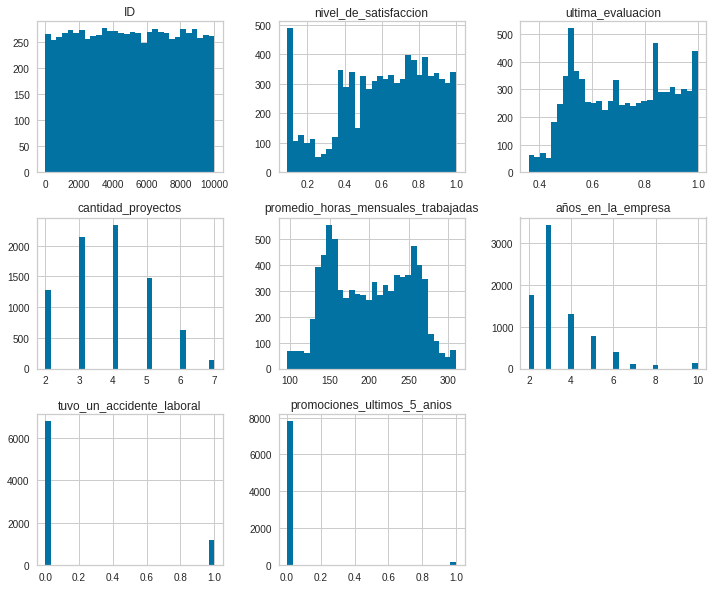

In [15]:
data[vars_num].hist(bins=30, figsize=(12,10))
plt.show()

1) ID: Naturalmente no brinda mucha info pues es único para cada persona, candidata a borrarse.

2) nivel_de_satisfacción: Se observa una gran cantidad de personas con satisfacción 0. Podría ser que los valores en realidad sean missing values o que 0 sea el default cuanddo no se contestó, entonces debiera imputar los 0's, pero no me parece descabellado que mucha gente manifieste disconformidad de esta manera, es discutible y dependerá del contexto de los datos. Independientemente de lo mencionado, esta variable parece ser poco útil si la tratamos de manera cuantitativa. Tal vez sería mejor pasarla a categórica bajo cierto criterio.

3) última_evaluación: parece haber una bajada abrupta desde aprox 0.45 para abajo. 

4) cantidad_proyectos: es discreta y la mayoría de personas hizo entre 3 y 4. 

5) promedio_horas_mensuales_trabajadas: se observan dos picos, uno por 150 y otro por 250, lo cual puede asociarse a los tipos de jornadas laborales día completo o medio día. 

6) años_en_la_empresa: la mayoría hace 3 años que están en empresa.

7) tuvo_un_acidente_laboral: la mayoría de las personas no tuvo accidente laboral, o al menos sería lo más lógico pensar que 0 se corresponde a 'no'. Esta variable puede pasarse a cualitativa para analizarla un toque más. 

8) promociones_ultimos_5_anios: similar a la variable anterior, la mayoría no tuvo promociones. 

In [9]:
# 1) Borro la columna de ID's
data = data.drop(['ID'], axis=1)

In [10]:
# 2) Pasemos a categórica la variable nivel_de_satisfacción

# Vamos a dividir por intervalos: 
#    Pésimo [0,4), Regular[4,6), Bueno[0,8), Excelente[8,10]

def convert_satisfaction(value):
  
    if value < 0.4:
        return "Pésimo"
    elif (value >= 0.4 and value < 0.6):
        return 'Regular'
    elif (value >= 0.6 and value < 0.8):
        return 'Bueno'
    else:
        return "Excelente"
    
data['nivel_de_satisfaccion'] = data['nivel_de_satisfaccion'].apply(convert_satisfaction)

In [11]:
# 7) Pasemos a categórica tuvo_un_accidente_laboral
data['tuvo_un_accidente_laboral'] = data['tuvo_un_accidente_laboral'].apply(lambda value: 'no' if value == 0 else "si")

In [12]:
# 8) También pasemos a categórica promociones_ultimos_5_anios
data['promociones_ultimos_5_anios'] = data['promociones_ultimos_5_anios'].apply(lambda value: 'no' if value == 0 else "si")

#### Correlaciones

<AxesSubplot:>

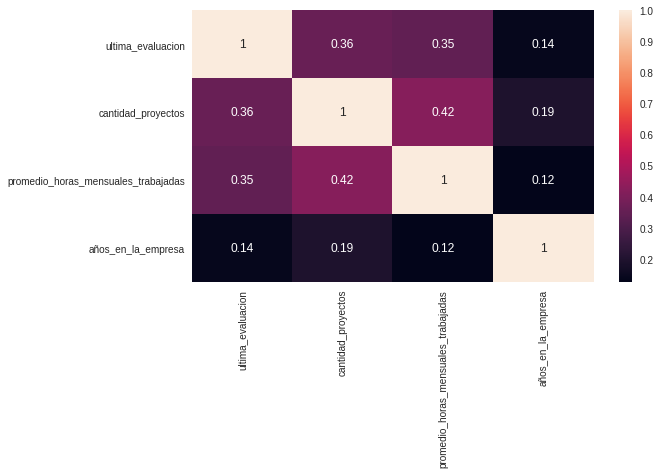

In [13]:
plt.figure(figsize=(9, 5))
sns.heatmap(data.corr(), annot=True)

Veo cierta correlación entre variables pero no tan marcada. Por lo que en principio no debiera analizar correlaciones expurias, eliminar aquellas muy correlacionadas, o hacer una reducción de dimensionalidad. A priori todo sirve.

La mayor correlación es entre cantidad de proyectos y horas trabajadas. Esto tiene total lógica, más proyectos más tiempo requerido. Luego le sigue ultima evaluacion con cantidad de proyectos e inmediatamente ultima evaluacion con promedio de horas mensuales trabajadas.

Hagamos unos gráficos para ver la realción de todas estas variables con la variable target: 

<AxesSubplot:xlabel='años_en_la_empresa', ylabel='Density'>

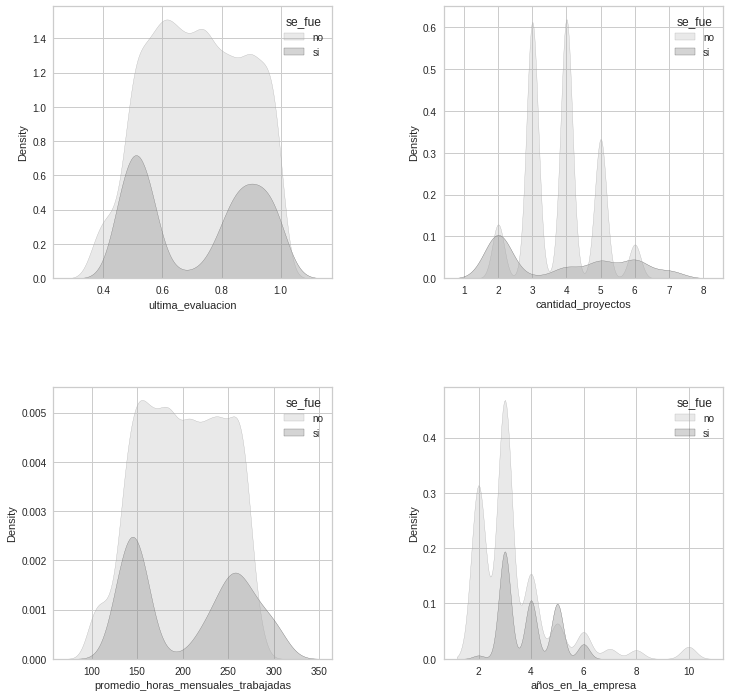

In [14]:
fig = plt.figure(figsize=(12, 12))
fig.subplots_adjust(hspace=0.4, wspace=0.4)
ax = fig.add_subplot(2, 2, 1)
sns.kdeplot(x='ultima_evaluacion', data=data, hue='se_fue', fill='se_fue', ax=ax, palette='binary')
ax = fig.add_subplot(2, 2, 2)
sns.kdeplot(x='cantidad_proyectos', data=data, hue='se_fue', fill='se_fue', ax=ax, palette='binary')
ax = fig.add_subplot(2, 2, 3)
sns.kdeplot(x='promedio_horas_mensuales_trabajadas', data=data, hue='se_fue', fill='se_fue', ax=ax, palette='binary')
ax = fig.add_subplot(2, 2, 4)
sns.kdeplot(x='años_en_la_empresa', data=data, hue='se_fue', fill='se_fue', ax=ax, palette='binary')

Aquí podemos ver varias cosas: 
- Respecto a última evaluación, claramente hay dos regiones de personas que se fueron, esto es por las zonas de 0.3 y 0.9 aprox. Podríamos pensar que las peores y mejores evaluaciones son mas propensas a irse, en tanto que las intermedias no.  
- Respecto a cantidad de proyectos, la mayor cantidad de personas que se van son aquellas que tenían 2 proyectos, luego en menor medida aquellas que tenían 5 y 6. Muy marcada la diferencia en el caso de tener 3 proyectos: la mayoría no se va.
- Respecto a promedio de horas mensuales trabajadas ocurre algo muy similar a la variable ultima_evaluacion.. dos regiones bien marcadas para quienes se van, en torno a 150 y 260 horas. 
- Respecto a años en la empresa, nuevamente hay distinciones interesantes: aquellos que tienen 2 años no se van por lo general, y luego si se van en mayor medida los de 3,4 y 5 años. Incluso a los 5 años es más la gente que se va de la que se queda.  

Este análisis permite concluir que todas las variables son interesantes.

#### Outliers

Recordar que ahora hay nuevas categóricas 

In [15]:
vars_num = [c for c in data.columns if data[c].dtypes!='O' and c!=target]

vars_cat = [c for c in data.columns if data[c].dtypes=='O' and c!=target]

print('Numero de variables numericas: {}'.format(len(vars_num)))
print('Numero de variables categoricas: {}'.format(len(vars_cat)))

Numero de variables numericas: 4
Numero de variables categoricas: 5


Text(0.5, 1.0, 'Boxplot $\\frac{x-u}{\\sigma}$')

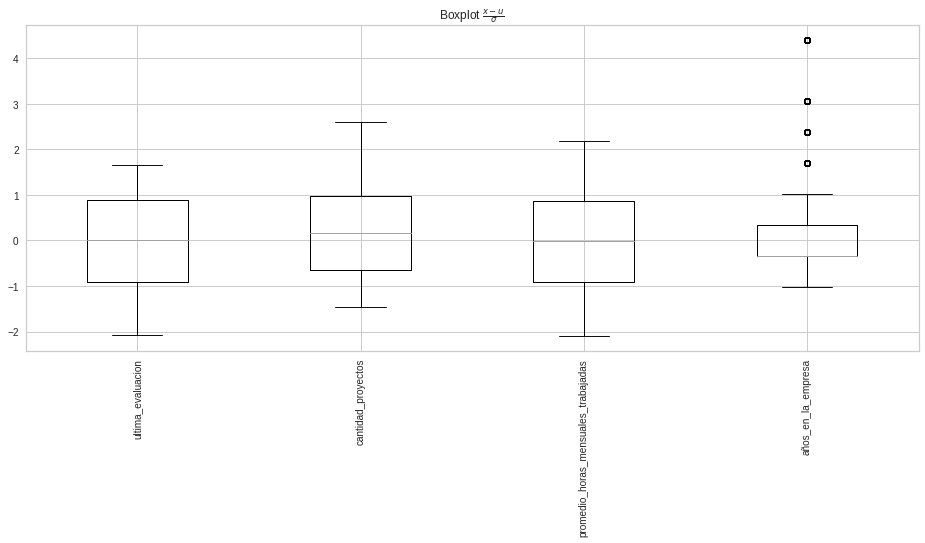

In [16]:
std=data[vars_num].std(axis=0)
mean = data[vars_num].mean(axis=0)
boxplot = data[vars_num].sub(mean).div(std).boxplot(figsize=(16,6))
plt.xticks(rotation='vertical')
plt.title(r'Boxplot $\frac{x-u}{\sigma}$')

En general no se detectan Outleirs, salvo en años_en_la_empresa pero que son propios de la distribución (jefes, líderes, dueños, etc). Podría eliminarlos pero en principio no son datos raros, así que los mantengo.  

### Análisis de Variables categóricas

Veamos cardinalidad y valores 

In [17]:
# exploremos los valores
for var in vars_cat:
    print(var,': tiene',data[var].nunique(),'valores')
    print(data[var].unique())
    print('\n')

nivel_de_satisfaccion : tiene 4 valores
['Bueno' 'Pésimo' 'Regular' 'Excelente']


tuvo_un_accidente_laboral : tiene 2 valores
['no' 'si']


promociones_ultimos_5_anios : tiene 2 valores
['no' 'si']


area : tiene 10 valores
['gestión de productos' 'tecnica' 'ventas' 'dirección' 'contabilidad'
 'ImásD' 'marketing' 'RRHH' 'soporte' 'TI']


salario : tiene 3 valores
['bajo' 'alto' 'medio']




<AxesSubplot:>

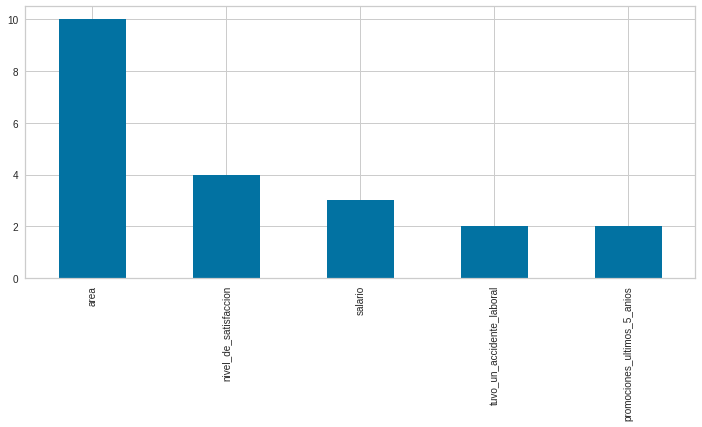

In [18]:
# mas graficamente
data[vars_cat].nunique().sort_values(ascending=False).plot.bar(figsize=(12,5))

Todas las variables categóricas muestran baja cardinalidad, esto significa que tienen pocos labels diferentes. Esto es bueno ya que no necesitamos abordar el problema de cardinalidad durante el feature engineering. 

In [19]:
# proporción de labels por categoría
for var in vars_cat:
    print(var,'\n',data[var].value_counts()/len(data[var]))
    print('\n')

nivel_de_satisfaccion 
 Bueno        0.282250
Excelente    0.279500
Regular      0.239875
Pésimo       0.198375
Name: nivel_de_satisfaccion, dtype: float64


tuvo_un_accidente_laboral 
 no    0.85125
si    0.14875
Name: tuvo_un_accidente_laboral, dtype: float64


promociones_ultimos_5_anios 
 no    0.977625
si    0.022375
Name: promociones_ultimos_5_anios, dtype: float64


area 
 ventas                  0.275875
tecnica                 0.186125
soporte                 0.147250
TI                      0.080250
gestión de productos    0.061500
marketing               0.055250
ImásD                   0.053875
RRHH                    0.049875
contabilidad            0.049375
dirección               0.040625
Name: area, dtype: float64


salario 
 bajo     0.48675
medio    0.43150
alto     0.08175
Name: salario, dtype: float64




Podemos ver que la mayor cantidad de personas NO tuvo un accidente laboral, ni tuvo promociones durante los últimos 5 años.

Por otro lado, la mayor parte del personal es de ventas, seguido por tecnica y soporte. 

Respecto a los salarios, casi la mitad son bajos y menos del 10% altos.

#### Pivoteo entre variables
Veamos más analiticamente la relación entre estas variables y la variables que queremos predecir 'Se_fue'

In [21]:
data['se_fue'] = data['se_fue'].map(dict(si=1, no=0))

In [22]:
for var in vars_cat:
    print(data[[var, 'se_fue']].groupby([var], as_index=False).mean().sort_values(by='se_fue', ascending=False))
    print('\n')

  nivel_de_satisfaccion    se_fue
2                Pésimo  0.534972
3               Regular  0.279833
1             Excelente  0.131485
0                 Bueno  0.092117


  tuvo_un_accidente_laboral    se_fue
0                        no  0.264317
1                        si  0.073950


  promociones_ultimos_5_anios    se_fue
0                          no  0.240123
1                          si  0.055866


                   area    se_fue
1                  RRHH  0.265664
8               tecnica  0.258563
6             marketing  0.253394
9                ventas  0.246942
7               soporte  0.245331
3          contabilidad  0.240506
5  gestión de productos  0.213415
2                    TI  0.211838
0                 ImásD  0.153132
4             dirección  0.150769


  salario    se_fue
1    bajo  0.297124
2   medio  0.198436
0    alto  0.070336




- De acuerdo al nivel de satisfacción, la mayor parte de personas que se fueron son las que manifestaron Pésimo, seguidas por Regular.
- Según accidente laboral, se va más gente que NO tuvo, pero son muy pocos los que tuvieron así que no es tan clara la relación. Lo mismo ocurre con promociones los útlimos 5 años. 
- Por área no hay grandes diferencias pero sí entre los extremos: RRHH es en la que más se van, y en la que menos dirección lo cual es lógico pues la dirección es un cargo importante de mantener. 
- Respecto a salarios, mayormente se van los de salarios bajos, y los de altos se van poco. 

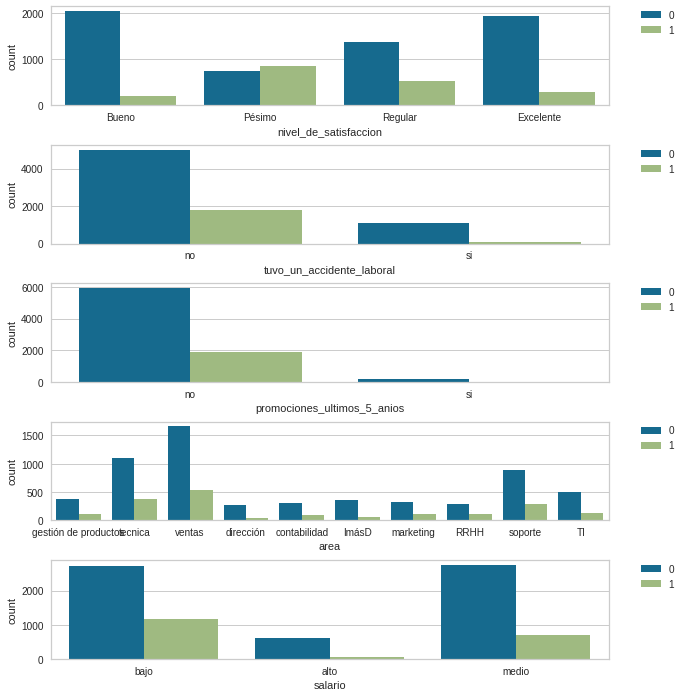

In [26]:
# Veamos el análisis anterior de manera más gráfica
fig = plt.figure(figsize=(10, 12))
fig.subplots_adjust(hspace=0.4, wspace=0.4)
ax = fig.add_subplot(5, 1, 1)
sns.countplot(x='nivel_de_satisfaccion', data=data, hue='se_fue', ax=ax)
plt.legend(loc=2, bbox_to_anchor = (1.05,1), borderaxespad=0.)
ax = fig.add_subplot(5, 1, 2)
sns.countplot(x='tuvo_un_accidente_laboral', data=data, hue='se_fue', ax=ax)
plt.legend(loc=2, bbox_to_anchor = (1.05,1), borderaxespad=0.)
ax = fig.add_subplot(5, 1, 3)
sns.countplot(x='promociones_ultimos_5_anios', data=data, hue='se_fue', ax=ax)
plt.legend(loc=2, bbox_to_anchor = (1.05,1), borderaxespad=0.)
ax = fig.add_subplot(5, 1, 4)
sns.countplot(x='area', data=data, hue='se_fue', ax=ax)
plt.legend(loc=2, bbox_to_anchor = (1.05,1), borderaxespad=0.)
ax = fig.add_subplot(5, 1, 5)
sns.countplot(x='salario', data=data, hue='se_fue', ax=ax)
plt.legend(loc=2, bbox_to_anchor = (1.05,1), borderaxespad=0.)

### Labesl Rare

Veamos si hay labels que están presentes sólo en una proporción pequeña (menor al 1%)

In [27]:
def analyse_rare_labels(df, var, rare_perc):
    df = df.copy()

    tmp = df[var].value_counts()/len(df[var])
    # return categories that are rare
    return tmp[tmp < rare_perc]

# veamos las categorías que estań presentes hasta el
# 1 % de las observaciones

for var in vars_cat:
    print(analyse_rare_labels(data, var, 0.01))
    print()

Series([], Name: nivel_de_satisfaccion, dtype: float64)

Series([], Name: tuvo_un_accidente_laboral, dtype: float64)

Series([], Name: promociones_ultimos_5_anios, dtype: float64)

Series([], Name: area, dtype: float64)

Series([], Name: salario, dtype: float64)



No hay labels que estén menos de 1% en proporción que puedan producir over-fitting de los modelos. Por lo tanto no hace falta etiquetar como raras ni condensarlas en otra.

## Algunas gráficas
Dado que no hay missing values ni otras cosas extrañas para hacer más cosas, hagamos algunas gráficas sólo por placer: 

In [62]:
# Defino una función para graficar variables categóricas vs numéricas
def density_plus_box(categorical, numerical):
    
    fig = plt.figure(figsize=(14, 6))
    fig.subplots_adjust(hspace=0.4, wspace=0.4)
    
    ax = fig.add_subplot(1, 2, 1)
    sns.kdeplot(x=numerical,data=data, hue=categorical, fill=categorical, ax=ax)
    
    ax = fig.add_subplot(1, 2, 2)
    sns.boxplot(x=categorical, y=numerical, data=data, palette='rainbow', ax=ax)
    plt.xticks(rotation=45)

In [63]:
vars_num

['ultima_evaluacion',
 'cantidad_proyectos',
 'promedio_horas_mensuales_trabajadas',
 'años_en_la_empresa',
 'se_fue']

In [65]:
vars_cat

['nivel_de_satisfaccion',
 'tuvo_un_accidente_laboral',
 'promociones_ultimos_5_anios',
 'area',
 'salario']

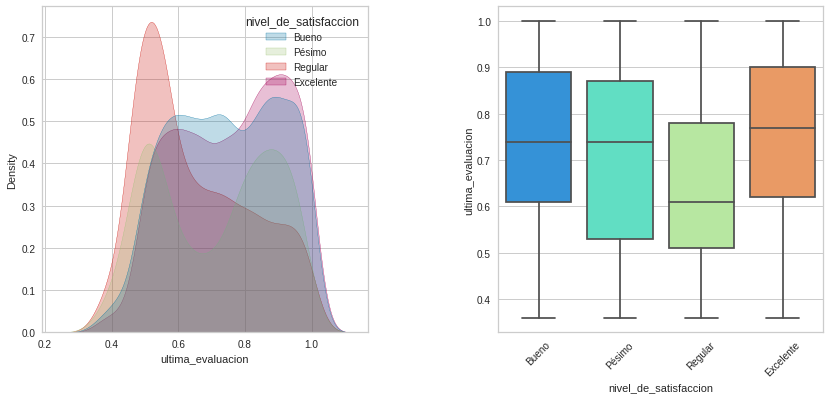

In [66]:
density_plus_box('nivel_de_satisfaccion','ultima_evaluacion')

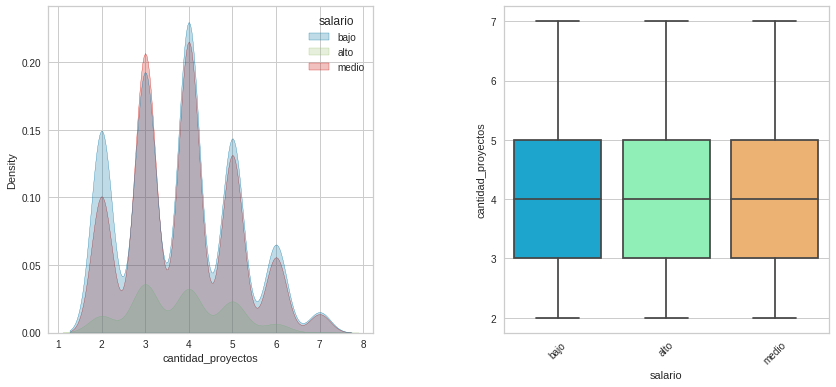

In [77]:
density_plus_box('salario','cantidad_proyectos')

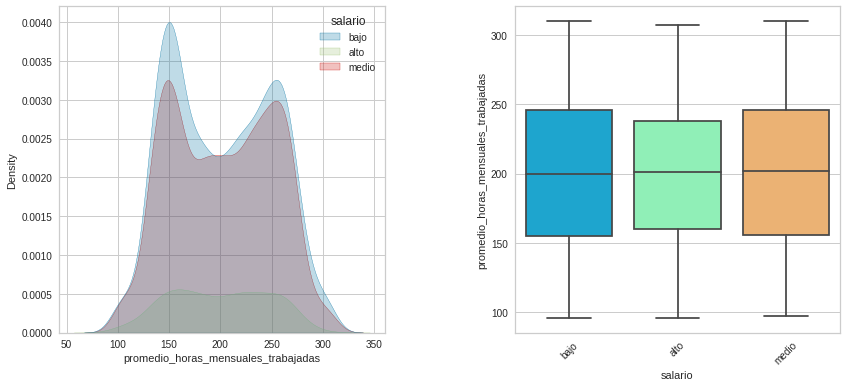

In [72]:
density_plus_box('salario','promedio_horas_mensuales_trabajadas')

# Feature Engineering

Con todo el análisis previo puedo decir que la mayoría de las variables son interesantes para incluir en el modelo, salvo la de ID y algunos cambios realizados en base a las observaciones. 

## Separo dataset en train y validation

Debo setear una semilla 

In [28]:
vars_num = [c for c in data.columns if data[c].dtypes!='O']
vars_cat = [c for c in data.columns if data[c].dtypes=='O' and c!=target]

In [29]:
# Separemos la data 

X_train, X_val, y_train, y_val = train_test_split(
    data.drop(['se_fue'], axis=1), 
    data['se_fue'], 
    test_size=0.1,
    random_state=0,
)

X_train.shape, X_val.shape

((7200, 9), (800, 9))

In [30]:
X_train[vars_cat].nunique()

nivel_de_satisfaccion           4
tuvo_un_accidente_laboral       2
promociones_ultimos_5_anios     2
area                           10
salario                         3
dtype: int64

In [31]:
X_val[vars_cat].nunique()

nivel_de_satisfaccion           4
tuvo_un_accidente_laboral       2
promociones_ultimos_5_anios     2
area                           10
salario                         3
dtype: int64

### Transformación a one-hot encoding de las variables categóricas

In [32]:
for var in vars_cat:
    
    # to create the binary variables, we use get_dummies from pandas
    
    X_train = pd.concat([X_train,
                         pd.get_dummies(X_train[var], prefix=var, drop_first=True)
                         ], axis=1)
    
    X_val = pd.concat([X_val,
                        pd.get_dummies(X_val[var], prefix=var, drop_first=True)
                        ], axis=1)
    

X_train.drop(labels=vars_cat, axis=1, inplace=True)
X_val.drop(labels=vars_cat, axis=1, inplace=True)

X_train.shape, X_val.shape

((7200, 20), (800, 20))

In [33]:
# creemos una variable de las variables para posibles futuros cambios
variables = [c  for c in X_train.columns]
variables

['ultima_evaluacion',
 'cantidad_proyectos',
 'promedio_horas_mensuales_trabajadas',
 'años_en_la_empresa',
 'nivel_de_satisfaccion_Excelente',
 'nivel_de_satisfaccion_Pésimo',
 'nivel_de_satisfaccion_Regular',
 'tuvo_un_accidente_laboral_si',
 'promociones_ultimos_5_anios_si',
 'area_RRHH',
 'area_TI',
 'area_contabilidad',
 'area_dirección',
 'area_gestión de productos',
 'area_marketing',
 'area_soporte',
 'area_tecnica',
 'area_ventas',
 'salario_bajo',
 'salario_medio']

## Feature scaling
Escaleamos las variables a sus mínimos y máximos valores, podría usar el StandarScaler si asumo que la data tiene una distribución normal. 

Algunos modelos no requieren dicho escaleo (de hecho los que voy a usar no lo requieren) pero por si quisiera usar algún modelo que sí lo requiera lo hago a modo de mostrar conocimiento. 

In [34]:
# create scaler
scaler = MinMaxScaler()

#  fit  the scaler to the train set
scaler.fit(X_train) 

# transform the train and test set
X_train = pd.DataFrame(
    scaler.transform(X_train),
    columns=X_train.columns)

X_val = pd.DataFrame(
    scaler.transform(X_val),
    columns=X_train.columns)

In [35]:
X_train.head()

,ultima_evaluacion,cantidad_proyectos,promedio_horas_mensuales_trabajadas,años_en_la_empresa,nivel_de_satisfaccion_Excelente,nivel_de_satisfaccion_Pésimo,nivel_de_satisfaccion_Regular,tuvo_un_accidente_laboral_si,promociones_ultimos_5_anios_si,area_RRHH,area_TI,area_contabilidad,area_dirección,area_gestión de productos,area_marketing,area_soporte,area_tecnica,area_ventas,salario_bajo,salario_medio
0,0.328125,0.2,0.289720,0.125,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
1,0.515625,0.2,0.261682,0.000,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
2,0.406250,0.4,0.728972,0.000,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
3,0.515625,0.4,0.266355,0.125,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
4,0.703125,0.8,0.696262,0.250,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0


In [36]:
# guardemos el set train y test  
X_train.to_csv('xtrain.csv', index=False)
X_val.to_csv('xval.csv', index=False)

y_train.to_csv('ytrain.csv', index=False)
y_val.to_csv('yval.csv', index=False)

In [37]:
# y guardemos el scaler también 
joblib.dump(scaler, 'minmax_scaler.joblib') 

['minmax_scaler.joblib']

Aquí termina la parte de feature engineering

# Modelos

Estamos en una situación de datos un tanto desbalanceados, entonces la métrica Accuracy puede no resultar conveniente. Estudio el área bajo la curva ROC (tal vez también las métricas Recall y Precision, pero sería más bien para mejorar el modelo). 
Para mejorar los modelos con desbalance, en caso que lo amerite, podría proponer lo siguiete: 
- Undersampling
- Overssampling

## Baseline prediction
Predicciones de la clase mayoritaria para comparación 

In [38]:
y_val_base = pd.Series(np.zeros(len(y_val)))

## Logistic Regression 

In [39]:
logit = LogisticRegression(random_state=0,  max_iter=1000)

logit.fit(X_train, y_train)

LogisticRegression(max_iter=1000, random_state=0)

## Random Forest

In [40]:
rf = RandomForestClassifier(n_estimators=100, random_state=0)

rf.fit(X_train, y_train)

RandomForestClassifier(random_state=0)

## LightGBM

In [41]:
light_gbm = lgb.LGBMClassifier()

light_gbm.fit(X_train, y_train)

LGBMClassifier()

## Predicciones y comparación de modelos 

### ROC-AUC

In [42]:
print('ROC-AUC Baseline val: {}'.format(roc_auc_score(y_val, y_val_base)))
print('ROC-AUC Logistic Regression val: {}'.format(roc_auc_score(y_val, logit.predict_proba(X_val)[:,1])))
print('ROC-AUC Random Forest val: {}'.format(roc_auc_score(y_val, rf.predict_proba(X_val)[:,1])))
print('ROC-AUC LightGBM val: {}'.format(roc_auc_score(y_val, light_gbm.predict_proba(X_val)[:,1])))

ROC-AUC Baseline val: 0.5
ROC-AUC Logistic Regression val: 0.7980892688201108
ROC-AUC Random Forest val: 0.985868022705771
ROC-AUC LightGBM val: 0.9893144343830247


# Optimización y validación cruzada del mejor modelo

Busco mejorar parámetros del modelo LightGBM con la mejor ROC-AUC mediante GridSearchCV considerando también una validación cruzada (con un foldeado de 5) para tener un valor mas real.

In [43]:
from sklearn.model_selection import GridSearchCV, KFold

In [44]:
model = lgb.LGBMClassifier()

parameters = {
    'objective': ['binary'],
    'learning_rate': [0.005, 0.01, 0.1],
    'verbose': [0],
    "num_leaves": [32,64,128],
    "max_depth": [6, 8, 10],
    "silent": [True],
    "n_estimators": [100,1000]
}

n_splits = 5
kfold_5 = KFold(shuffle = True, n_splits = n_splits)

search = GridSearchCV(model, 
                           parameters, 
                           cv=kfold_5,  
                           n_jobs=-1,
                           verbose=True)

search.fit(X_train, y_train)

Fitting 5 folds for each of 54 candidates, totalling 270 fits
[LightGBM] [Warning] Find whitespaces in feature_names, replace with underlines
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000311 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No furth

GridSearchCV(cv=KFold(n_splits=5, random_state=None, shuffle=True),
             estimator=LGBMClassifier(), n_jobs=-1,
             param_grid={'learning_rate': [0.005, 0.01, 0.1],
                         'max_depth': [6, 8, 10], 'n_estimators': [100, 1000],
                         'num_leaves': [32, 64, 128], 'objective': ['binary'],
                         'silent': [True], 'verbose': [0]},
             verbose=True)

In [46]:
# veamos los mejores parámetros obtenidos
print(search.best_params_)

{'learning_rate': 0.1, 'max_depth': 10, 'n_estimators': 100, 'num_leaves': 64, 'objective': 'binary', 'silent': True, 'verbose': 0}


Podría seguir encontrando los parámetros comparando valores en torno a los mejore obtenidos, sin embargo procedo y evalúo el modelo con los mejores parámetros que encontré hasta el momento

In [47]:
final_light_gbm = lgb.LGBMClassifier(num_leaves=64, 
                                     max_depth=10, 
                                     learning_rate=0.1, 
                                     n_estimators=100, 
                                     objective='binary')

final_light_gbm.fit(X_train, y_train)

LGBMClassifier(max_depth=10, num_leaves=64, objective='binary')

In [49]:
# finalmente queda nuestro modelo final evaluado con un valor más realista
print('ROC-AUC LightGBM val: {}'.format(roc_auc_score(y_val, final_light_gbm.predict_proba(X_val)[:,1])))

ROC-AUC LightGBM val: 0.9858595756183268


In [50]:
# finalmente guardemos nuestro mejor modelo
joblib.dump(final_light_gbm,'model.joblib') 

['model.joblib']

### Anexo: Precision t Recall vs Umbrales de probabilidad 

Veamos este gráfico para mejorar las predicciones variando el umbral de probabilidad y tomar como base para la mejora del modelo. 

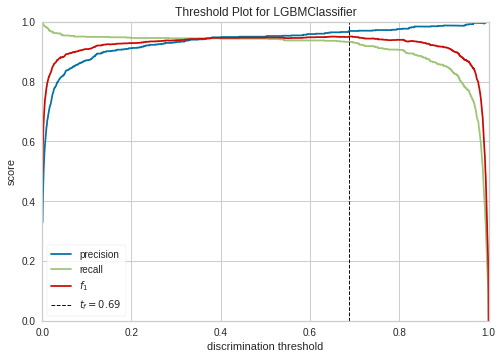

<AxesSubplot:title={'center':'Threshold Plot for LGBMClassifier'}, xlabel='discrimination threshold', ylabel='score'>

In [51]:
visualizer = DiscriminationThreshold(final_light_gbm,
                                     n_trials=1,
                                     cv=0.5,
                                     argmax='fscore',
                                     random_state=0,
                                     is_fitted='auto',
                                     exclude = "queue_rate")

visualizer.fit(X_train, y_train)        # Fit el visualizador y el modelo
visualizer.score(X_val, y_val)        # Evaluatos el modelo en la data de validación
visualizer.show()

Un buen parámetro suele ser tomar el mayor valor de F1 score para determinar el umbral (en este caso próximo a 0.7), esto queda sometido a discusión. Podríamos sin embargo variar el umbral: 

In [57]:
# desde aquí podemos variar el umbral 
threshold = 0.7

predicted_proba = final_light_gbm.predict_proba(X_val)[:,1]
predicted = (predicted_proba >= threshold).astype('int')

print('Precision', precision_score(y_val, predicted))
print('Recall ', recall_score(y_val, predicted))
print('F1 score ', f1_score(y_val, predicted))

Precision 0.9633507853403142
Recall  0.9387755102040817
F1 score  0.9509043927648579


# Predicciones 

In [71]:
# cargo los datos
data_test = pd.read_csv('Evaluación Técnica - Applied Intelligence/test.csv')

print(data_test.shape)
data_test.head()

(2000, 11)


,ID,nivel_de_satisfaccion,ultima_evaluacion,cantidad_proyectos,promedio_horas_mensuales_trabajadas,años_en_la_empresa,tuvo_un_accidente_laboral,promociones_ultimos_5_anios,area,salario,se_fue
0,2.0,0.40,0.57,2,152,3,0,0,ventas,bajo,NaN
1,4.0,0.54,0.52,3,115,3,0,0,contabilidad,bajo,NaN
2,9.0,0.72,0.87,5,223,5,0,0,ventas,bajo,NaN
3,14.0,0.65,0.67,3,245,3,0,0,ventas,medio,NaN
4,15.0,0.54,0.95,4,256,3,0,0,soporte,bajo,NaN


In [72]:
# veamos que no haya missing values en variables numericas
target = 'se_fue'
vars_num = [c for c in data_test.columns if data_test[c].dtypes!='O']
vars_cat = [c for c in data_test.columns if data_test[c].dtypes=='O' and c!=target]

In [73]:
# var numericas
data_test[vars_num].isnull().sum()

ID                                        0
nivel_de_satisfaccion                     0
ultima_evaluacion                         0
cantidad_proyectos                        0
promedio_horas_mensuales_trabajadas       0
años_en_la_empresa                        0
tuvo_un_accidente_laboral                 0
promociones_ultimos_5_anios               0
se_fue                                 2000
dtype: int64

In [74]:
# var categoricas
data_test[vars_cat].isnull().sum()

area       0
salario    0
dtype: int64

Excelente, no hay missing values 

## Feature engineer del set test

In [75]:
# 1) Borro la columna de ID's
data_test = data_test.drop(['ID'], axis=1)

# 2) Pasemos a categórica la variable nivel_de_satisfacción    
data_test['nivel_de_satisfaccion'] = data_test['nivel_de_satisfaccion'].apply(convert_satisfaction)

# 7) Pasemos a categórica tuvo_un_accidente_laboral
data_test['tuvo_un_accidente_laboral'] = data_test['tuvo_un_accidente_laboral'].apply(lambda value: 'no' if value == 0 else "si")

# 8) También pasemos a categórica promociones_ultimos_5_anios
data_test['promociones_ultimos_5_anios'] = data_test['promociones_ultimos_5_anios'].apply(lambda value: 'no' if value == 0 else "si")

In [76]:
# Borro la columna 'se_fue'
data_test = data_test.drop(['se_fue'], axis=1)

In [77]:
vars_num = [c for c in data_test.columns if data_test[c].dtypes!='O']
vars_cat = [c for c in data_test.columns if data_test[c].dtypes=='O' and c!=target]

print('Numero de variables numericas: {}'.format(len(vars_num)))
print('Numero de variables categoricas: {}'.format(len(vars_cat)))

Numero de variables numericas: 4
Numero de variables categoricas: 5


In [78]:
# one-hot encoding version
for var in vars_cat:
     
    data_test = pd.concat([data_test,
                        pd.get_dummies(data_test[var], prefix=var, drop_first=True)], axis=1)
    

data_test.drop(labels=vars_cat, axis=1, inplace=True)

data_test.shape

(2000, 20)

In [81]:
# escaleamos con el scaler utilizado: 
data_test = pd.DataFrame(scaler.transform(data_test), columns=data_test.columns)

In [82]:
data_test.head()

,ultima_evaluacion,cantidad_proyectos,promedio_horas_mensuales_trabajadas,años_en_la_empresa,nivel_de_satisfaccion_Excelente,nivel_de_satisfaccion_Pésimo,nivel_de_satisfaccion_Regular,tuvo_un_accidente_laboral_si,promociones_ultimos_5_anios_si,area_RRHH,area_TI,area_contabilidad,area_dirección,area_gestión de productos,area_marketing,area_soporte,area_tecnica,area_ventas,salario_bajo,salario_medio
0,0.328125,0.0,0.261682,0.125,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0
1,0.250000,0.2,0.088785,0.125,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,0.796875,0.6,0.593458,0.375,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0
3,0.484375,0.2,0.696262,0.125,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
4,0.921875,0.4,0.747664,0.125,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0


## Calculamos y guardamos predicciones en formato pedido

In [87]:
# ejemplo de como debo presentar datos
ejemplo = pd.read_csv('Evaluación Técnica - Applied Intelligence/submission.csv')
ejemplo.head()

,ID,se_fue
0,2.0,NaN
1,4.0,NaN
2,9.0,NaN
3,14.0,NaN
4,15.0,NaN


In [ ]:
# predicciones
pred = final_light_gbm.predict(data_test)
# recupero los ID's
ID = pd.read_csv('Evaluación Técnica - Applied Intelligence/test.csv')['ID']

In [110]:
# Creo el dataframe correspondiente
d = {'ID':ID,'se_fue':pred}

predicciones = pd.DataFrame(data=d)
predicciones.head()

,ID,se_fue
0,2.0,1
1,4.0,0
2,9.0,1
3,14.0,0
4,15.0,0


In [111]:
# guardemos las predicciones en formato .csv  
predicciones.to_csv('predicciones.csv', index=False)

Aquí termina el challenge! Saludos! 